## Описание проекта:

Мы работаем с воображаемой добывающей компаний.

## Цель проекта:

Нужно решить, где лучше бурить новую скважину.

* Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. * Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
* Проанализировать возможную прибыль и риски техникой *Bootstrap.*

*Шаги для выбора локации:*

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [19]:
import sys; print(sys.version)
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

import warnings
warnings.simplefilter("ignore")

3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]


In [2]:
#загрузим данные каждого региона
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

display(geo_data_0.head())
display(geo_data_1.head())
display(geo_data_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [3]:
#проверим отсутствие пропусков и типы данных
display(geo_data_0.info())
display(geo_data_1.info())
display(geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Пропусков нет. Типы данные корректные.

In [4]:
#общие статистики данных
display(geo_data_0.describe())
display(geo_data_1.describe())
display(geo_data_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


По общему описанию, можно сказать что объем запасов продукта по региону 1 и 3 практически одинаковы. А вот параметры нефти у каждого региона разные

In [5]:
#проверим нет ли одинаковых строк

display(geo_data_0.duplicated().sum())
display(geo_data_1.duplicated().sum())
display(geo_data_2.duplicated().sum())

0

0

0

Дублирующие строки отсутствуют

In [6]:
#проверим нет ли одинаковых названий скважин

display(geo_data_0['id'].duplicated().sum())
display(geo_data_1['id'].duplicated().sum())
display(geo_data_2['id'].duplicated().sum())

10

4

4

In [7]:
#посмотрим сколько строк дублируют каждое название скважин

display(geo_data_0['id'].value_counts().head(11))
display(geo_data_1['id'].value_counts().head())
display(geo_data_2['id'].value_counts().head())

AGS9W    2
74z30    2
HZww2    2
fiKDv    2
TtcGQ    2
bxg6G    2
A5aEY    2
bsk9y    2
QcMuo    2
Tdehs    2
zZfpQ    1
Name: id, dtype: int64

5ltQ6    2
LHZR0    2
wt4Uk    2
bfPNe    2
MlrBM    1
Name: id, dtype: int64

xCHr8    2
VF7Jo    2
KUPhW    2
Vcm5J    2
URNxa    1
Name: id, dtype: int64

Итого 36 строк из 30000 суммарно по всем данным являются дубирующими по признаку id. Их можно удалить либо оставить, так как такое количество данных не скажется на обучение модели.

In [8]:
a = geo_data_0['id'].value_counts().head(11)
display(geo_data_0.query('id in @a.index'))

#display(geo_data_1['id'].value_counts().head())
#display(geo_data_2['id'].value_counts().head())

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


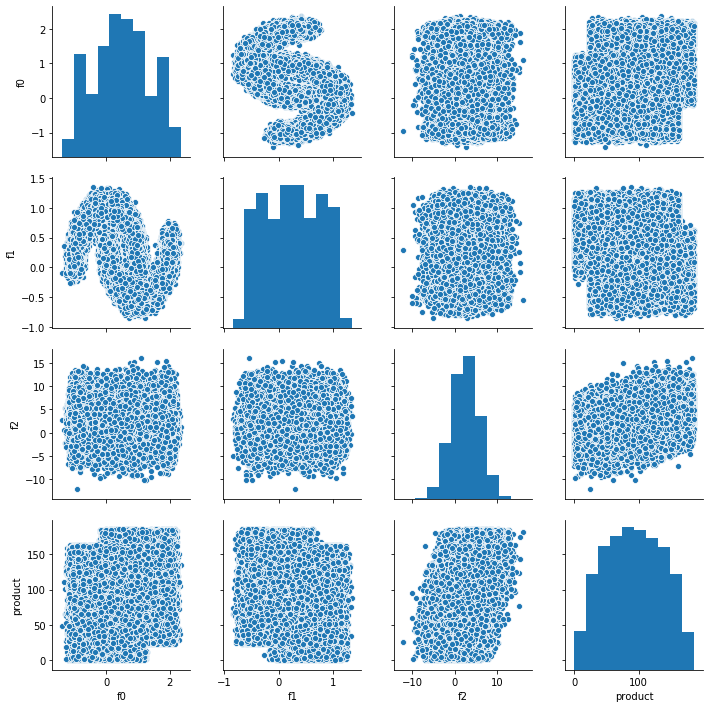

In [9]:
#посмотрим на зависимость параметров между собой региона 1

sns.pairplot(geo_data_0)

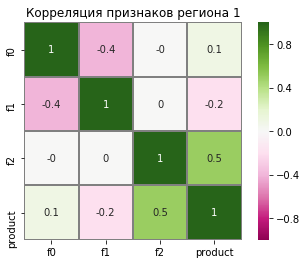

In [10]:
#проверим нет ли мультиколлинеарности между параметрами
#matrix = np.triu((round(geo_data_0.corr(), 1)))
#mask=matrix
sns.heatmap(
    round(geo_data_0.corr(), 1),
    annot = True, fmt = '.0g', square = True,
    vmin=-1, vmax=1,
    center= 0,
    linewidths=1,
    linecolor='grey',
    #mask=matrix,
    cmap= 'PiYG'
)
sns.set(rc={'figure.figsize':(5.0,5.0)})
plt.title('Корреляция признаков региона 1')
plt.show()

Все параметры по региону 1 имеют нормальное распределение. Имеется средняя зависимость обьема продукта от параметра f2. Мультиколлинеарность параметров отсутствует.

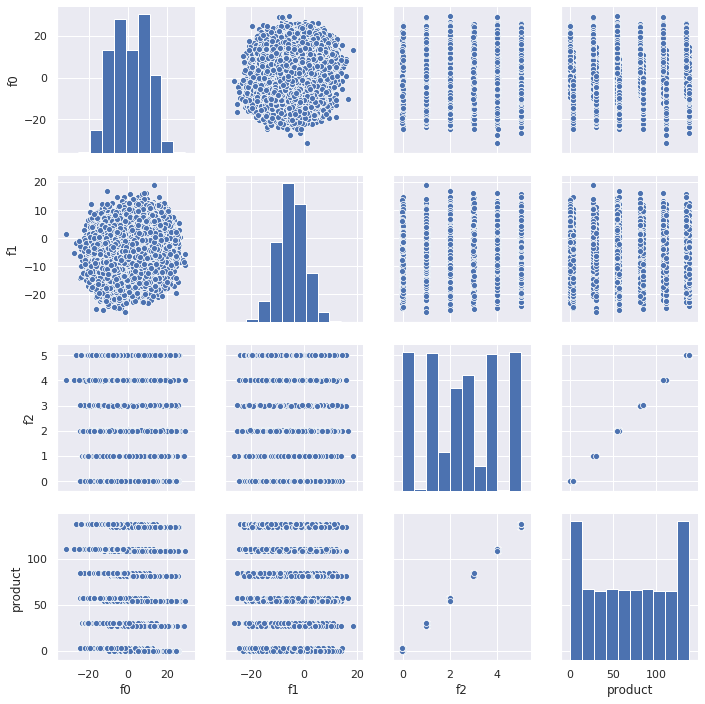

In [11]:
#посмотрим на зависимость параметров между собой региона 2

sns.pairplot(geo_data_1)

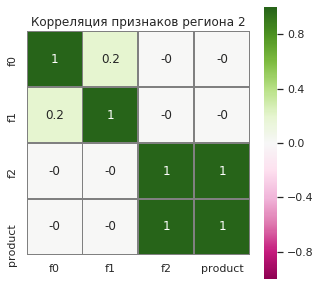

In [12]:
sns.heatmap(
    round(geo_data_1.corr(), 1),
    annot = True, fmt = '.4g', square = True,
    vmin=-1, vmax=1,
    center= 0,
    linewidths=1,
    linecolor='grey',
    cmap= 'PiYG'
)
sns.set(rc={'figure.figsize':(5.0,5.0)})
plt.title('Корреляция признаков региона 2')
plt.show()

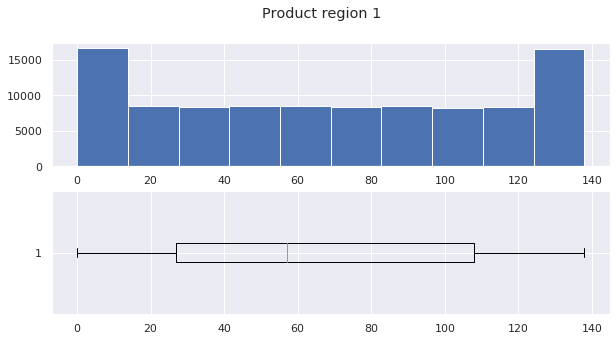

In [13]:
#строим гистограмму и боксплот для продукта региона 2
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].hist(geo_data_1['product'], bins=10)
axes[1].boxplot(geo_data_1['product'], showfliers=True, vert=False)
plt.suptitle("Product region 1")
plt.show()

In [15]:
#категоризируем виды продуктов
def category_product(row):
    if row < 20:
        return 'min'
    if  row > 120:
        return 'max'
    else:
        return 'medium'
geo_data_1['product_cat'] = geo_data_1['product'].apply(category_product)
display(geo_data_1['product_cat'].value_counts(normalize=True))

medium    0.66891
min       0.16572
max       0.16537
Name: product_cat, dtype: float64

In [16]:
#удалим дополнительный столбец, так как он не нужен нам при моделировании
display(geo_data_1.drop(['product_cat'], axis=1, inplace=True))

None

Параметры f0 и f1 по региону 2 имеют нормальное распределение, данные по параметру product равнораспределны, хотя имеетя 30% данных, которые приближаются к минимуму и максимуму. Наблюдается сильная зависимость обьема продукта от параметра f2. Мультиколлинеарность параметров отсутствует

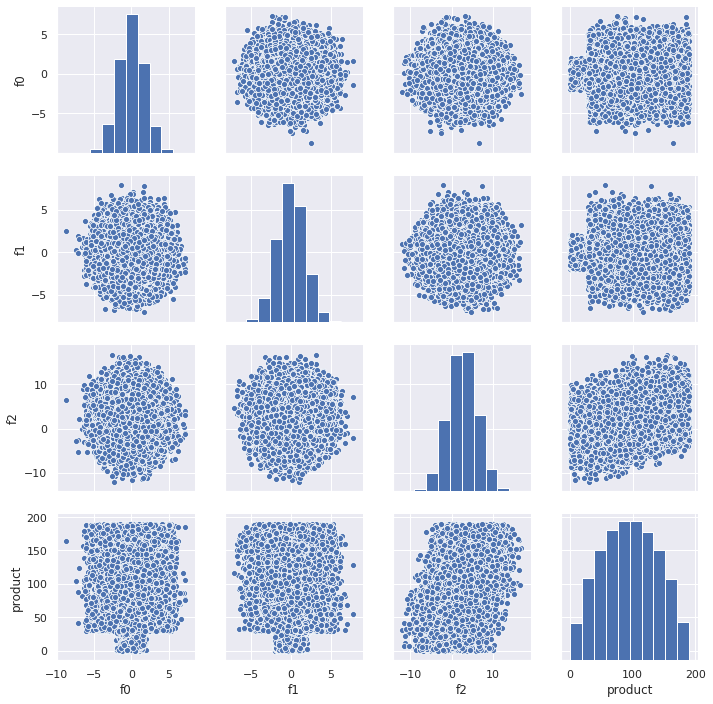

In [17]:
#посмотрим на зависимость параметров между собой региона 3

sns.pairplot(geo_data_2)

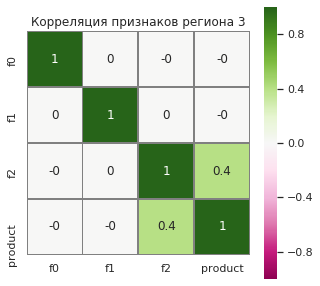

In [18]:
sns.heatmap(
    round(geo_data_2.corr(), 1),
    annot = True, fmt = '.0g', square = True,
    vmin=-1, vmax=1,
    center= 0,
    linewidths=1,
    linecolor='grey',
    cmap= 'PiYG'
)
sns.set(rc={'figure.figsize':(5.0,5.0)})
plt.title('Корреляция признаков региона 3')
plt.show()

Все параметры по региону 3 имеют нормальное распределение.Также наблюдается средняя зависимость обьема продукта от параметра f2 как и по двум другим регионам. Мультиколлинеарность параметров отсутствует

# Вывод
* Первый взгляд на данные выполнен. Данные подготовлены к дальнейшему использованию. 
* Пропусков и дубликатов нет. Аномалий по значениям также
* Каждый датасет содержит 10000 строк. 
* Типы данных в столбцах соответствуют содержащимся в них данным.
* Не все значения id в датасетах уникальны. Но мы уже решили, что их количество не скажется на качестве модели, поэтому не будем обрабатывать дубликат
* Распределения признаков в основном похожи на нормальные. Хотя во втором регионе geo_data_1 встречаются и явно ненормальные распределения у признака f2 и product.

## Обучение и проверка модели

В этом разделе мы будем обучать модели линейной регрессии для каждого региона, чтобы предсказать запасы нефти в месторождениях по набору абстрактных признаков f. Основной метрикой качества наших моделей будет RMSE: Она более чувствительна к большим ошибкам, чем MAE.

In [18]:
#создадим таблицы с признаками и отдельно с целевым признаком по каждому региону
features_0 = geo_data_0.drop(['product', 'id'], axis=1)
features_1 = geo_data_1.drop(['product', 'id'], axis=1)
features_2 = geo_data_2.drop(['product', 'id'], axis=1)

target_0 = geo_data_0['product']
target_1 = geo_data_1['product']
target_2 = geo_data_2['product']

display(features_0.shape)
display(features_1.shape)
display(features_2.shape)

(100000, 3)

(100000, 3)

(100000, 3)

In [19]:
#разбиваем на обучающую и валидационную, валидационной отводим 25% всех данных
#регион 1
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345
)
display(features_train_0.shape)
display(features_valid_0.shape)

(75000, 3)

(25000, 3)

In [20]:
#регион 2
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345
)
display(features_train_1.shape)
display(features_valid_1.shape)

(75000, 3)

(25000, 3)

In [21]:
#регион 3
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345
)
display(features_train_2.shape)
display(features_valid_2.shape)

(75000, 3)

(25000, 3)

In [22]:
#строим модель линейной регресси, обучаем модель, находим предсказания и среднеквадратичную ошибку
#регион 1
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
predictions_0 = model_0.predict(features_valid_0)
mse_0 = mean_squared_error(target_valid_0, predictions_0)
rmse_0 = mse_0 ** 0.5

#регион 2
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predictions_1 = model_1.predict(features_valid_1)
mse_1 = mean_squared_error(target_valid_1, predictions_1)
rmse_1 = mse_1 ** 0.5

#регион 3
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predictions_2 = model_2.predict(features_valid_2)
mse_2 = mean_squared_error(target_valid_2, predictions_2)
rmse_2 = mse_2 ** 0.5


In [23]:
#сравним итоги обученных моделей по каждому региону
df = (
    {'Regions':
     ['Region_1', 'Region_2', 'Region_3'],
     'Средний запас предсказанного сырья': [round(predictions_0.mean()),
                                            round(predictions_1.mean()),
                                            round(predictions_2.mean())],
     'RMSE': [round(rmse_0, 2),
              round(rmse_1, 2),
              round(rmse_2, 2)],
     'Средние запасы скважин': [round(target_valid_0.mean(), 2),
                      round(target_valid_1.mean(), 2),
                      round(target_valid_2.mean(), 2)]}
)
models_results = pd.DataFrame(df)
models_results.columns = pd.MultiIndex.from_product([['Качество модели по регионам'], models_results.columns])
display(models_results)

Качество модели по регионам                                            \
                      Regions Средний запас предсказанного сырья   RMSE   
0                    Region_1                                 93  37.58   
1                    Region_2                                 69   0.89   
2                    Region_3                                 95  40.03   

                          
  Средние запасы скважин  
0                  92.08  
1                  68.72  
2                  94.88

# Вывод
* Мы обучили отдельные модели для каждого региона.
* Сделали предсказания запасов нефти для валидационной выборки по каждому месторождению.
* Оценили качество моделей метрикой RMSE.
* Пока что наиболее перспективным вариантом для нас выглядят регионы 1 и 3, потому что их средние предсказанные значения запасов выше, чем среднее в регионе 2.
* Однако среднеквадратичная ошибка ниже (а значит лучше качесто модели) у региона под номером 2.

# 3. Подготовка к расчёту прибыли

In [79]:
#зафиксируем ключевые константные переменные
COST = 450 #стоимость одной тысячи баррелей продукта
BUDGET = 10000000 #бюджет на разработку 200 скважин в регионе

#сохраним итоги предсказаний добычи сырья по каждому региону

#регион 1
predict_prod_0 = pd.Series(predictions_0)

#регион 2
predict_prod_1 = pd.Series(predictions_1)

#регион 3
predict_prod_2 = pd.Series(predictions_2)

display(predict_prod_0.describe(), predict_prod_1.describe(), predict_prod_2.describe())

count    25000.000000
mean        92.592568
std         23.176994
min         -9.367846
25%         76.652232
50%         92.661884
75%        108.437632
max        180.180713
dtype: float64

count    25000.000000
mean        68.728547
std         46.010225
min         -1.893774
25%         28.536661
50%         57.851586
75%        109.346485
max        139.818970
dtype: float64

count    25000.000000
mean        94.965046
std         19.853733
min         17.131597
25%         81.388500
50%         95.031204
75%        108.492663
max        165.856833
dtype: float64

In [58]:
#рассчитываем точку безубыточности - т.е. определить необходимый объем сырья, покрываемый затраты
prod_effect = BUDGET / COST / 200
print("Безубыточный объем сырья:", round(prod_effect))

Безубыточный объем сырья: 111


In [60]:
#сравним безубыточный объем сырья со средним предсказанным объемом по каждому региону

prod_effect_0 = (pd.DataFrame(predict_prod_0, columns=['Product_1'])['Product_1'].sort_values(ascending=False).head(200)).mean()
prod_effect_1 = (pd.DataFrame(predict_prod_1, columns=['Product_2'])['Product_2'].sort_values(ascending=False).head(200)).mean()
prod_effect_2 = (pd.DataFrame(predict_prod_2, columns=['Product_3'])['Product_3'].sort_values(ascending=False).head(200)).mean()

df_1 = (
    {'Regions':
     ['Region_1', 'Region_2', 'Region_3'],
     'Средний объем предсказанного сырья': [round(prod_effect_0, 2),
                                            round(prod_effect_1, 2),
                                            round(prod_effect_2, 2)],
     'Запас сырья': [round((prod_effect_0 - prod_effect), 2),
                      round((prod_effect_1 - prod_effect), 2),
                      round((prod_effect_2 - prod_effect), 2)]}
)
products = pd.DataFrame(df_1)
products.columns = pd.MultiIndex.from_product([['Запасы сырья'], products.columns])
display(products)

Запасы сырья                                               
       Regions Средний объем предсказанного сырья Запас сырья
0     Region_1                             155.51       44.40
1     Region_2                             138.73       27.62
2     Region_3                             148.02       36.91

# Вывод
* Все скважины показывают высокий запас сырья относительно точки безубыточности.

## Расчёт прибыли и рисков

Напишем формулу для расчета прибыли

In [80]:
#функция для расчета прибыли
def profit(predictions, targets):
    preds = predictions.sort_values(ascending=False).head(200)
    targets = targets.reset_index(drop=True)[preds.index]
    profit = ((targets.sum()) * COST - BUDGET)
    return profit

Применим Bootstrap для нахождения распределения прибыли. Так мы поймём, какие у нас перспективы при нашем подходе к разработке месторождений.
* Вычислим границы 95% доверительного интервала для средней прибыли в каждом регионе.

In [75]:
from numpy.random import RandomState
from scipy import stats as st
state = np.random.RandomState(12345)

SAMPLE = 1000 #количество выборок для Bootstrap
ITEMS = 500 #количество исследуемых точек(скважин) в регионе

def profit_interval(target, predictions):   
    values = []
    for i in range(SAMPLE):
        pred_subsample = predictions.sample(n=ITEMS, replace=True, random_state=state)
        res = profit(pred_subsample, target)
        values.append(res)
    
    values = pd.Series(values)
    mean = values.mean()

    risk =  (values<0).mean() * 100

    #confidence_interval = st.t.interval(0.9, len(values)-1, mean, values.sem())    
    lower = round(values.quantile(.025), 2)
    upper = round(values.quantile(.975), 2)
    confidence_interval = (lower, upper)
    
    print("Средняя выручка:", round(mean, 2))
    print("Риск убытков:", round(risk, 2), "%")
    print("95% доверительный интервал:", confidence_interval)

print("По региону 1")
profit_interval(target_valid_0, predict_prod_0)
print("")
print("По региону 2")
profit_interval(target_valid_1, predict_prod_1)
print("")
print("По региону 3")
profit_interval(target_valid_2, predict_prod_2)

По региону 1
Средняя выручка: 396164.98
Риск убытков: 6.9 %
95% доверительный интервал: (-111215.55, 909766.94)

По региону 2
Средняя выручка: 461155.82
Риск убытков: 0.7 %
95% доверительный интервал: (78050.81, 862952.06)

По региону 3
Средняя выручка: 392950.48
Риск убытков: 6.5 %
95% доверительный интервал: (-112227.63, 934562.91)


## Вывод
* Только в регионе 2 в наш 95%-й доверительный интервал не попадают отрицательные значения прибыли. Это означает, что шансы попасть на безубыточный набор скважин в регионах 1 и 3 явно ниже 95%, а во втором регионе мы с очень большой долей вероятности попадём в прибыльные места.
* Однако у региона 2 есть и обратная сторона медали: верхняя граница доверительного интервала 95% ниже, чем в 1 или 3. Соответственно, в регионе 2 у нас не такие высокие шансы получить прибыль, возможную в двух других местах.
* Регион 2 внушает наибольшее доверие, поскольку риски, связанные с эти регионом, меньше всего.
* Вероятность попаст в убытки выше всего в регионе 1 и 3, они оказываются в наименее выигрышным состоянии.

## Выбор региона
Чтобы выбрать оптимальный регион, нам нужно понимать, насколько компания готова к рискам в виде возможных убытков, и здесь есть два варианта:

**Компания готова к возможным убыткам** - в таком случае интереснее будет рассмотреть регион 3, поскольку потенциальная доходность будет максимальной, а вероятность убытка - минимально возможной.  

**Компания рассчитывает только на прибыль** - тогда мы рекомендуем регион 2: компания получит прибыль более, чем с 95% вероятностью, хоть и не сможет рассчитывать на максимально возможную историяю в отношении прибыли.

## Общий вывод
* Мы обучили модели линейной регрессии, оценивающие запас сырья в скважинах для трёх разных регионов. 
* Использовали технику bootstrap, чтобы смоделировать распределение потенциальной прибыли от разных регионов c учётом нашего бюджета и возможностей для разработки.
* По полученному распределению определили:
  * Среднюю прибыль, на которую мы можем рассчитывать.
  * Доверительный интервал - границы диапазона значений, в который с 95% вероятностью окажется наша прибыль.
  * Вероятность отрицательной прибыли, то есть убытков.

Проанализировали вышенайденные показатели регионов и пришли к выводу, что наиболее оптимальный вариант - это **регион 2**, поскольку он меньше прочих сопряжён с рисками. Регион 3 имеет потенциально высокую прибыль и меьшей вероятностью убытков в нём больше. Регион 1 - не будем рекомендовать, потому что у него нет преимуществ перед двумя другими.